## CP#21 - Medical X-Ray Image Classifier: Pneumonia Detection

### Importing libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import cv2
from sklearn.metrics import precision_score, recall_score
import os

### Function definitions

In [2]:
# Function prints information on number of files in folder structure
def count_files_in_subdirs(root_dir):
    for split in ['train', 'val', 'test']:
        split_path = os.path.join(root_dir, split)
        print(f'\n{split.upper()} SET:')
        
        if os.path.exists(split_path):
            for class_name in os.listdir(split_path):
                class_path = os.path.join(split_path, class_name)
                if os.path.isdir(class_path):
                    num_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
                    print(f'  {class_name}: {num_files} plików')
        else:
            print(f'  Folder {split} does not exists.')

### Script parameters and constant values

In [3]:
local_dir_dataset ="../../data" 
local_dir_train = "../../data/train"
local_dir_test = "../../data/test"
local_dir_val = "../../data/val"
device = torch.device("cpu")
xysize = 64


### Preprocessing the Dataset

In [4]:
# Statistical analysis of files in dataset after balancing TRAIN - NORMAL SET 
count_files_in_subdirs(local_dir_dataset)


TRAIN SET:
  NORMAL: 4024 plików
  PNEUMONIA: 3876 plików

VAL SET:
  NORMAL: 9 plików
  PNEUMONIA: 9 plików

TEST SET:
  NORMAL: 234 plików
  PNEUMONIA: 390 plików


In [5]:
transform_train = transforms.Compose([
    transforms.Grayscale(num_output_channels=1), # grayscale
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),    
    transforms.Resize((xysize, xysize)), #output size
    transforms.RandomApply(  # random blur, probability = 0.3
        [transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 5.0))],
        p=0.3  # 30% of train set will be blured
    ),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5]) # general normalization for grayscale
])

In [6]:
transform_test = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((xysize, xysize)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [7]:
dataset_train = datasets.ImageFolder(root=local_dir_train, transform=transform_train)
dataset_test = datasets.ImageFolder(root=local_dir_test, transform=transform_test)
dataset_val = datasets.ImageFolder(root=local_dir_val, transform=transform_test)

In [8]:
train_loader = DataLoader(dataset_train, batch_size=32, shuffle=True)
test_loader = DataLoader(dataset_test, batch_size=32, shuffle=False)
val_loader = DataLoader(dataset_val, batch_size=32, shuffle=False)

### Data Visualization

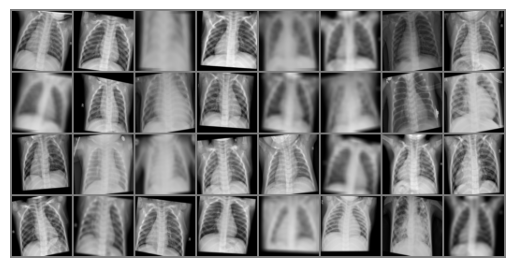

In [9]:
# Function to visualize a batch of images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5])
    std = np.array([0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

plt.axis('off')
imshow(out, title="")

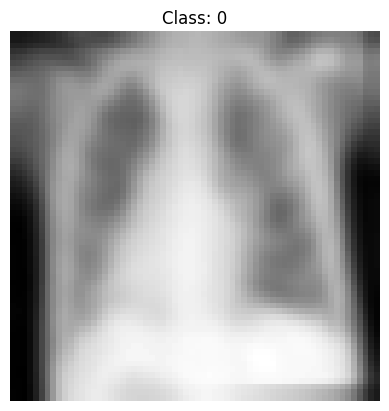

In [10]:
image = inputs[4]  # Torch.Size([1, 128, 128])

# denormalization
mean = 0.5
std = 0.5
image = image * std + mean 

# 
image = image.squeeze()

# visualzaton in grayscale
plt.imshow(image, cmap='gray')
plt.title(f'Class: {classes[0]}')
plt.axis('off')
plt.show()

### 1-layer Convolutional Nerual Network architecure

In [ ]:
class BasicCNN(nn.Module):
    def __init__(self):
        super(BasicCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        # in_channels=3 - RGB, 1 - B&W
        # out_channels=32 - how many filters
        # kernel_size=3 - size of the filter
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(32*xysize*xysize, 6)
        # 32 - number of filters
        # 128 * 128 - size of the image
        # 6 - number of output classes (building, firest, glacier, mountain, sea, street)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)

        return x

In [ ]:
model = BasicCNN()
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Training the model
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Obliczanie accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total * 100
    
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

In [ ]:
# Evaluate the model
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

### 3-layer Convolutional Nerual Network architecure

In [11]:
class BasicCNNV2(nn.Module):
    def __init__(self):
        super(BasicCNNV2, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()

        # Head of the CNN
        self.fc1 = nn.Linear(128 * (xysize // 8) * (xysize // 8), out_features=512)
        self.fc2 = nn.Linear(512, 6)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1) 
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x  

In [12]:
model = BasicCNNV2()
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [13]:
# Training the model
num_epochs = 30

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device, non_blocking=True), labels.to(device, non_blocking=True)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
        
        # Obliczanie accuracy
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct / total * 100
    
    # Walidacja
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    with torch.no_grad():
        for val_inputs, val_labels in test_loader:  # Upewnij się, że masz val_loader
            val_inputs, val_labels = val_inputs.to(device, non_blocking=True), val_labels.to(device, non_blocking=True)
            val_outputs = model(val_inputs)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item() * val_inputs.size(0)
            
            _, val_predicted = torch.max(val_outputs, 1)
            val_correct += (val_predicted == val_labels).sum().item()
            val_total += val_labels.size(0)

    val_epoch_loss = val_loss / len(val_loader.dataset)
    val_epoch_accuracy = val_correct / val_total * 100

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')
    print(f'Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%')


Epoch 1/30, Loss: 0.2124, Accuracy: 91.23%
Validation Loss: 15.7171, Validation Accuracy: 83.65%
Epoch 2/30, Loss: 0.1043, Accuracy: 96.11%
Validation Loss: 42.0530, Validation Accuracy: 72.12%
Epoch 3/30, Loss: 0.0800, Accuracy: 97.18%
Validation Loss: 23.1058, Validation Accuracy: 79.17%
Epoch 4/30, Loss: 0.0777, Accuracy: 97.01%
Validation Loss: 32.8323, Validation Accuracy: 76.76%
Epoch 5/30, Loss: 0.0700, Accuracy: 97.54%
Validation Loss: 34.2097, Validation Accuracy: 74.20%
Epoch 6/30, Loss: 0.0643, Accuracy: 97.91%
Validation Loss: 25.7047, Validation Accuracy: 81.25%
Epoch 7/30, Loss: 0.0584, Accuracy: 97.85%
Validation Loss: 48.3447, Validation Accuracy: 75.64%
Epoch 8/30, Loss: 0.0545, Accuracy: 98.04%
Validation Loss: 19.4362, Validation Accuracy: 82.05%
Epoch 9/30, Loss: 0.0502, Accuracy: 98.11%
Validation Loss: 23.2174, Validation Accuracy: 85.26%
Epoch 10/30, Loss: 0.0507, Accuracy: 98.23%
Validation Loss: 31.6351, Validation Accuracy: 78.21%
Epoch 11/30, Loss: 0.0401, Ac

In [14]:
model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

accuracy = correct / total
precision = precision_score(all_labels, all_predictions, average='macro')  # Możesz zmienić na 'micro' lub 'weighted'
recall = recall_score(all_labels, all_predictions, average='macro')

print(f'Validation Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')


Validation Accuracy: 82.21%
Precision: 0.8733
Recall: 0.7671


In [15]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
import torch.nn.functional as F

model.eval()
correct = 0
total = 0
all_labels = []
all_predictions = []
all_probs = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)

        probs = F.softmax(outputs, dim=1)  # Dla klasyfikacji wieloklasowej
        _, predicted = torch.max(probs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())  # Pobieramy prawdopodobieństwa

accuracy = correct / total
precision = precision_score(all_labels, all_predictions, average='macro')
recall = recall_score(all_labels, all_predictions, average='macro')
f1 = f1_score(all_labels, all_predictions, average='macro')

# AUC wymaga wartości prawdopodobieństwa dla każdej klasy
try:
    auc = roc_auc_score(all_labels, all_probs, multi_class="ovr")  # One-vs-Rest dla wieloklasowej klasyfikacji
except ValueError:
    auc = None  # Jeśli AUC nie da się obliczyć, np. w przypadku jednej klasy w danych

print(f'Validation Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
if auc is not None:
    print(f'AUC Score: {auc:.4f}')
else:
    print('AUC Score: Not computable (possibly due to class imbalance)')


Validation Accuracy: 82.21%
Precision: 0.8733
Recall: 0.7671
F1 Score: 0.7858
AUC Score: Not computable (possibly due to class imbalance)
